In [40]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/9/26 22:24
# @Author  : Wang Yujia
# @File    : GT_asc_symmetry_gen.ipynb
# @Description : 根据GT_asc_symmetry_gen_demo.ipynb，计算ascending-price auction的data。ref：信息不对称的paper里symmetry的情况。

# 0. what for
1. 在`GT_asc_symmetry_gen_demo.ipynb`上实验过的思路，现在automatically执行一下，输入所有的auction setting，得到相应的输出
2. **Steps**：
    - collect GT计算需要的features: `features_GT`，记得给target data留一个flag:`unique_setting`
        - features_GT = ['bidincrement','bidfee','retail']
        - unique_setting = ['product_id', 'bidincrement', 'bidfee','retail']
    - 根据`features_GT`计算GT预测的结果`n`和`p`

# 1. Preparations
## 1.1 全局设置

In [24]:
# 经过threshold==16 filter之后，得到的dataset
#data_selected_path = "../data/info_asymm/datawithnp_asc_symmetry_2_selected.csv"
data_selected_path = "../data/info_asymm/datawithnp_asc_symmetry_selected.csv"

# output path
data_path_root = "../data/info_asymm/results/asc_symmetry/"
# target data is from method-2
filename_head = "GT_asc_symmetry_2_"
filename_tail = ".csv"

# GT计算需要的features
# 实际上不需要'product_id'这个属性。对于GT来说'retail'就足以反映product信息
features_GT = ['bidincrement','bidfee','retail']

# 最后给data新增3列预测结果
features_added = ['P_1','Q_1','K_1']

# threshold，在下面定义了
# K=min(Q)

import numpy as np
#import cupy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [8]:
# cupy test
#x_gpu = np.ones((8,8))
#x_gpu.mean()

array(1.)

## 1.2 读取data

In [25]:
data = pd.read_csv(data_selected_path, encoding="utf-8")

# 2. GT_model: ascending-price auction model in symmetry situation
## 2.1 提取GT计算需要的features和data
1. 注意`drop_duplicates()`的目的是，对GT model来说，它的setting和NN的setting是不一样的，这里只需要要保留GT计算需要的setting就好
2.

In [26]:
# 2.1.1 extract data
data_for_GT = data[features_GT].copy()
data_for_GT = data_for_GT.drop_duplicates().copy()
print("For symmetry GT model in ascending-price auctions, there are *{}* settings waiting to be inferred.".format(data_for_GT.shape[0]))

# 2.1.2 设置
b = np.array(data_for_GT.bidfee)          # bid fee (cent to dollar)
s = np.array(data_for_GT.bidincrement)    # bid increment (cent to dollar)
v = np.array(data_for_GT.retail)               # valuation
# 需要计算`A`组结果
A = data_for_GT.shape[0]

# 2.1.3 得到Key的函数
def get_key_from_index(i):
   key_i = list(data_for_GT[features_GT].iloc[i,:])               # 取出key, 这里的key是GT的key，不是NN的
   # make sure key_i_str is tuple which is hashable
   key_i_str = (str(key_i[0]),str(key_i[1]),str(key_i[2]))
   return key_i_str

# cupy
# def get_key_from_index(i):
#     key_i = list(data_for_GT[features_GT].iloc[i,:])               # 取出key, 这里的key是GT的key，不是NN的
#     # make sure key_i_str is tuple which is hashable
#     key_i_str = np.array([int(key_i[0]),int(key_i[1]),(key_i[2])])
#     return key_i_str

For symmetry GT model in ascending-price auctions, there are *57* settings waiting to be inferred.


## 2.2 Q and K
1. For ascending-price, there is $n \leq Q $
2. Q的大小应该为`A*1`，K的值是min(Q)


shape of Q:  (57,)
The largest Q is *554*, and the smallest one is *-30*
In average, Q is :  19.333333333333332
The median of Q is *0.0*
The threshold K is set as:  -30


([<matplotlib.axis.XTick at 0x1f95c559358>,
 <a list of 29 Text xticklabel objects>)

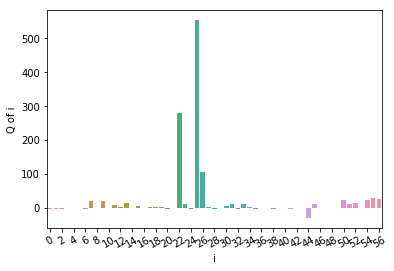

In [27]:
Q_a = np.floor((v-b)/s)
Q_a = np.array(Q_a.astype('int64'))
print("\nshape of Q: ",Q_a.shape)
print("The largest Q is *{0}*, and the smallest one is *{1}*".format(np.max(Q_a),np.min(Q_a)))
print("In average, Q is : ",Q_a.mean())
print("The median of Q is *{}*".format(np.median(Q_a)))

# threshold
K = min(Q_a)
print("The threshold K is set as: ",K)

# transform Q_a into Q_dict
Q = {}
for i in range(0,A):
    key_i = get_key_from_index(i)
    Q.update({key_i: Q_a[i]})

# distribution of Q
plt.xlabel("i")
plt.ylabel("Q of i")
ax = sns.barplot(x=np.arange(0,len(Q_a)),y=Q_a)
# 设置刻度
steps_xaxis = np.arange(0, len(Q_a), step=int(len(Q_a)/20))
plt.xticks(steps_xaxis,steps_xaxis,rotation=30)

In [12]:
# np.arange(0, len(Q_a), step=steps_xaxis)

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
       390, 420, 450, 480, 510, 540, 570, 600])

## 2.3 U
1. `U`作为一个**dict**，它的key是`features_GT`,每一个key对应一个大小为(Q+2)的list. 因此`U`的shape应该为：`A*(Q+2)`
2. 注意边界值：根据公式可知`U[key][0]`不存在，指定为1，方便后续`P`的计算
3. 对于某一个确定的setting，`U[key]`一共有`Q[key]`个有效数字，有效index从`1`开始，因此`U[key]`的长度is various depending on the `Q`
4. 因此`U[key][j]`表示在某一个setting下：
> The probability that somebody makes the jth bid (given that j − 1 previous bids have been made)

In [20]:
U = dict()

# for every uniq setting i
for i in tqdm(range(0,A),desc="U:"):
    # Get the key of i
    key_i = get_key_from_index(i)           # u[i][0]方便计算，统一设为1
    U[key_i] = np.array([1.0]*(Q[key_i]+2)) # 避免浅拷贝，请你这样写
    # for every period j in the auction with uniq setting i
    for j in range(1,Q[key_i]+2):
        U[key_i][j] = 1.0-b[i]/(v[i]-s[i]*(j-1))
    # assert(U[key_i].shape[0] == (Q[key_i]+2),"Wrong size of U")


print("U is Prepared Well")

U is Prepared Well


U::   0%|          | 0/612 [00:00<?, ?it/s]

U is Prepared Well


## 2.4 N
1. 容易获取N，在ascending-price下，它和Q直接相关

In [21]:
N = dict()

# for every uniq setting i
for i in tqdm(range(0,A),desc="N:"):
    key_i = get_key_from_index(i)              # Get the key of i
    N[key_i] = np.arange(0,Q[key_i]+1)
    assert(max(N[key_i]) == Q[key_i],"N[key_i]的最大值不是Q[i]")

print("N is Prepared Well.")

<ipython-input-21-104450f6de4e>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(max(N[key_i]) == Q[key_i],"N[key_i]的最大值不是Q[i]")


N::   0%|          | 0/612 [00:00<?, ?it/s]

N is Prepared Well.


## 2.5 P
1. `P`作为一个**dict**，它的key是`features_GT`,每一个key对应一个大小为(Q+2)的list. 因此`P`的shape应该为：`A*(Q+1)`
2. ~~对于某一个确定的setting，`P[key_i]`一共有`Q[i]`个有效数字，有效index从`0`开始，因此`P[key_i]`的长度is various depending on the `Q[i]`~~
3. **New**：由于threshold的存在，`P[key_i]`的大小设置为`K+1`，其中`p[key_i][K]`记录的是sum(P[i]) when i > K
4. 也就是说P[key_i][i]= sum(P[key_i][i]), when i>threshold

In [22]:
P = dict()

# for every uniq setting i
for i in tqdm(range(0,A),desc="P"):
    key_i = get_key_from_index(i)              # Get the key of i
    P[key_i] = np.array([0.0]*(K+1))
    tmp = np.array([0.0]*(K+2))                # tmp的大小不需要太精确
    tmp[0] = 1.0
    
    # for every period j in the auction with uniq setting i
    for j in range(0,K):
        tmp[j+1] = tmp[j]*U[key_i][j]
        P[key_i][j] = (1-U[key_i][j+1])*tmp[j+1]

    P[key_i][K] = 1-sum(P[key_i])

    # assert(len(P[key_i]) == len(N[key_i]),"P should record all the durations record in N")
    # print("The sum of P_{0} is: {1}".format(i,np.sum(P[key_i])))

print("\nP is Prepared Well.")

P:   0%|          | 0/612 [00:00<?, ?it/s]

The sum of P_0 is: 1.0
The sum of P_1 is: 1.0
The sum of P_2 is: 1.0
The sum of P_3 is: 0.9999999999999992
The sum of P_4 is: 0.9999999999999997
The sum of P_5 is: 1.0000000000000007
The sum of P_6 is: 1.0000000000000002
The sum of P_7 is: 1.0000000000000002
The sum of P_8 is: 1.0
The sum of P_9 is: 0.9999999999999999
The sum of P_10 is: 0.9999999999999999
The sum of P_11 is: 1.0000000000000007
The sum of P_12 is: 0.9999999999999999
The sum of P_13 is: 0.9999999999999993
The sum of P_14 is: 0.9999999999999998
The sum of P_15 is: 0.9999999999999996
The sum of P_16 is: 0.9999999999999998
The sum of P_17 is: 0.9999999999999991
The sum of P_18 is: 0.9999999999999998
The sum of P_19 is: 0.9999999999999981
The sum of P_20 is: 1.0000000000000002
The sum of P_21 is: 1.0
The sum of P_22 is: 1.0000000000000004
The sum of P_23 is: 0.999999999999999
The sum of P_24 is: 1.0000000000000002
The sum of P_25 is: 1.0
The sum of P_26 is: 1.0
The sum of P_27 is: 1.0000000000000002
The sum of P_28 is: 1.0


# 3. Dict Output
1. 每个unique setting对应着一组keys + 一个distrb
    - 输出3个csv文件，分别存储了`P,N,Keys`，前两者是dict直接输出
    - `P`的每一个item存储的是一个features_GT以及对应的distrb.
    - `N`的每一个item存储的是一个features_GT以及对应的duration array
    - `Keys`的每一个item存储的是一个features_GT，一共存储了`A`个
2. 输出`N`其实不太重要，主要是有`Q`和threashold `K`就足够了

In [23]:
filename_P = data_path_root+(filename_head + "P" + filename_tail)
filename_N = data_path_root+(filename_head + "N" + filename_tail)
filename_Q = data_path_root+(filename_head + "Q" + filename_tail)
filename_keys = data_path_root+(filename_head + "Keys" + filename_tail)

# P to csv
with open(filename_P,"w+",encoding='utf—8') as f:
    w=csv.writer(f)        # 每行存储一个键值对
    w.writerow(P.items())

# N to csv
with open(filename_N,"w+",encoding='utf—8') as f:
    w=csv.writer(f)                  # 每行存储一个键值对
    w.writerow(N.items())

# Q to csv
with open(filename_Q,"w+",encoding='utf—8') as f:
    w=csv.writer(f)                  # 每行存储一个键值对
    w.writerow(Q.items())

# Keys to csv
with open(filename_keys,"w+",encoding='utf—8',newline="") as f:
    w=csv.writer(f)
    # firstly write in the header
    w.writerow(features_GT)
    # for every uniq setting i
    for i in range(0,A):
        key = get_key_from_index(i)
        w.writerow(key)

print("Output is DONE")

Output is DONE


# 4. Test and Plot
## 4.1 plot
1. 根据指定的index进行画图，

In [ ]:
index_i = 28
key_i_forplot =  get_key_from_index(index_i)

plt.xlabel("Duration n")
plt.ylabel("The density p")
plt.title("bid increment={0}, bid fee={1}, retail={2}, Q={3}, K={4}".format(float(key_i_forplot[0])*0.01,float(key_i_forplot[1]),key_i_forplot[2],Q[key_i_forplot],K))

ax = sns.barplot(x = np.arange(0,len(P[key_i_forplot])),y=P[key_i_forplot])

# 设置刻度
steps_xaxis = np.arange(0, Q[index_i], step=steps_xaxis)
plt.xticks(steps_xaxis,steps_xaxis,rotation=30)

plt.show()
print("Plot is DONE")

# 5. Combination and merge
1. 不用merge，需要什么直接根据setting去取就好